<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C13_Skip_Lists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from typing import Any
from random import random

Utility function to pick a random level for each skip list node based on a constant probability p. The max_level is the maximum height allowed for a node, we return either the number of coin flips lower than p or max_height if we reached it.

In [45]:
p = 0.5

def pick_random_level(max_level: int) -> int:
    for i in range(max_level + 1):
        if random() >= p:
            return i

    return max_level

A SkipListNode class used to define the node of a Skip List. A node is defined by the following attributes:
* key = we assume that all key values are unique within the list and all nodes are sorted in ascending order based on this key
* value = the value stored by a node in the list
* height = the height of this node
* next = a list of pointers (based on node's height) to other nodes in the list. It's expected that higher levels skip across more nodes than lower levels based on the p distribution.

In [46]:
class SkipListNode:
    def __init__(self, key: Any, value: Any, height: int):
        self.key = key
        self.value = value
        self.height = height
        self.next = [None] * (height + 1)

A SkipList class used to define our skip list. The following attributes are used:
* top_level = the greatest height in any of the nodes in the list
* max_level = the maximum height that can be attained
* front = a pointer to the first node of the list. The front is a special node with no key and no value but a maximum height based on top_level

The skip list implements the following methods:
* search = lookup for a particular key returning the value contained there if the key exists in the list
* insert = used to add a new node with the given key and value. If the key already exists it simply updates the value. Our skip list does not allow duplicate keys.
* delete = removes a node identified by the given key if it exists in the list.

In [47]:
class SkipList:
    def __init__(self, max_level: int):
        self.top_level = 0
        self.max_level = max_level
        self.front = SkipListNode(None, None, max_level)

    def SkipListSearch(self, target: Any) -> Any:
        '''
        Returns the value of the node with the target key (or None if it doesn't exist).
        '''
        # Start the search with the current node at the front of the top-most list.
        current = self.front

        # The inner loop iterates through the current linked list until it hits
        # the end of the list or a node with a key >= target.
        # The outer loop drops down a single level each iteration until we hit
        # the bottom of the list.
        for level in range(self.top_level, -1, -1):
            while current.next[level] != None and current.next[level].key < target:
                current = current.next[level]
            # One improvement would be to terminate the loop earlier once we
            # found the target in the next node instead of iterating until we hit
            # the bottom.

        # When the loop ends we are guaranteed to be at the last node in the
        # list with a key less than the target.
        # If the target is in the list it will be at the next node.
        result = current.next[0]
        # Check that the node exists and has the correct key.
        if result != None and result.key == target:
            return result.value
        else:
            return None

    def SkipListInsert(self, key: Any, value: Any) -> None:
        current = self.front
        last = [current] * (self.max_level + 1)

        # The outer loop iterates through the list levels saving the last node
        # seen at each level before dropping down.
        for level in range(self.top_level, -1, -1):
            # The inner loop traverses the skip list moving forward every time
            # a node has a key less than our target
            while current.next[level] != None and current.next[level].key < key:
                current = current.next[level]
            # Update last for each level because we have seen that key at the
            # next node on that level is >= key to be inserted (or next node is null)
            # so we will need to insert before that node.
            last[level] = current

        result = current.next[0]
        # If we find a matching key then simply update that node value.
        if result != None and result.key == key:
            result.value = value
            return

        # When we find the correct point to insert the new node pick a random
        # level for this node.
        new_level = pick_random_level(self.max_level)
        if new_level > self.top_level:
            self.top_level = new_level
        new_node = SkipListNode(key, value, new_level)

        # Insert the new element by using a loop to update the pointers from
        # the new node to point to the correct following node.
        # Then update each of the nodes in last to point to our new node.
        for j in range(0, new_level + 1):
            new_node.next[j] = last[j].next[j]
            last[j].next[j] = new_node

    def SkipListDelete(self, target: Any) -> None:
        '''
        Deletes the node with the target key if it exists.
        First search the skip list for the deletion target while tracking the
        last node at each level that comes before the target node. Once the
        search is complete update the list of previous nodes to remove the node
        we are deleting.
        '''
        # Start at the top left of the list.
        current = self.front
        last = [current] * (self.max_level + 1)

        # Search each level until we find a node with key >= target or end of the list.
        for level in range(self.top_level, -1, -1):
            while current.next[level] != None and current.next[level].key < target:
                current = current.next[level]
            last[level] = current

        # Check if we found the node whose key matches the target. If not then
        # there's nothing to delete.
        result = current.next[0]
        if result == None or result.key != target:
            return

        level = result.height
        # Use a loop to simply link the next pointers for each node in the last
        # to point past the current node.
        for j in range(0, level + 1):
            last[j].next[j] = result.next[j]
            result.next[j] = None

        # Check if the skip list top level is still valid.
        if level == self.top_level:
            top = self.top_level
            while top > 0 and self.front.next[top] == None:
                top -= 1
            self.top_level = top


Utility function to draw a skip list by using the graphviz library. It uses a shape record to depict the levels of the node and the key of the node (to the left) as well as arrows representing the various next pointers for each node.

In [48]:
import graphviz

def visualize_skip_list(skip_list: SkipList) -> graphviz.Digraph:
    dot = graphviz.Digraph(node_attr={'shape':'record'})

    # First place all the nodes.
    current = skip_list.front
    while current != None:
        node_name = str(current.key) if current.key != None else 'Front'
        node_struct = []
        #node_struct = [f'Key: {node_name}']
        for level in range(current.height, -1, -1):
            node_struct.append(f'<l{level}> {level}')
        node_struct.append(f'Key: {node_name}')
        #dot.node(node_name, '{' + '|'.join(node_struct) + '}')
        dot.node(node_name, '|'.join(node_struct))
        current = current.next[0]

    # Then place all links
    current = skip_list.front
    while current != None:
        node_name = str(current.key) if current.key != None else 'Front'
        for level in range(current.height + 1):
            if current.next[level] != None:
                dot.edge(f'{node_name}:l{level}', f'{current.next[level].key}:<l{level}>')
        current = current.next[0]

    return dot



Some example of creating a skip list by inserting values. Irrespective of the order in which they are added the nodes are going to be sorted in ascending order.

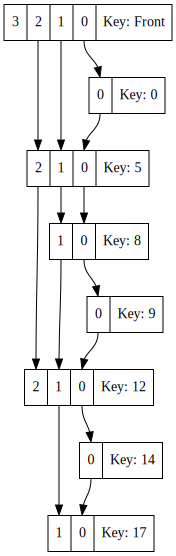

In [52]:
skip = SkipList(3)
skip.SkipListInsert(0, 0)
skip.SkipListInsert(8, 8)
skip.SkipListInsert(9, 9)
skip.SkipListInsert(17, 17)
skip.SkipListInsert(12, 12)
skip.SkipListInsert(14, 14)
skip.SkipListInsert(5, 5)

visualize_skip_list(skip)

Inserts another node in the proper place in the list.

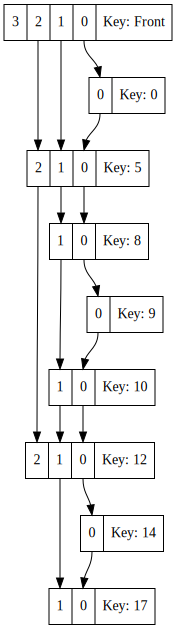

In [53]:
skip.SkipListInsert(10, 10)
visualize_skip_list(skip)

Searches for a key that exists and one that doesn't (returns None).

In [54]:
print(skip.SkipListSearch(10))
print(skip.SkipListSearch(11))

10
None


Removes the node with value 10.

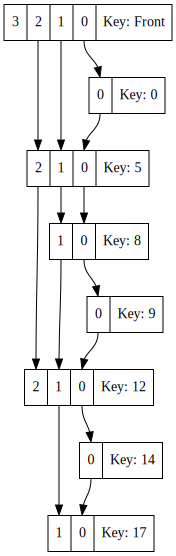

In [55]:
skip.SkipListDelete(10)
visualize_skip_list(skip)